In [ ]:
import sys
from simple_simulation_inverse_search import gates_set, matrix_list, add_inverse_gates
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip import (sigmax, sigmay, tensor)

import functools # for reduce
from qutip.qip.operations.gates import *
from qutip import basis
from qutip_qip.circuit import QubitCircuit
from qutip.metrics import fidelity
from qutip.qip.noise import RandomNoise

import numpy as np

import sys
from simple_simulation_inverse_search import gates_set, matrix_list, add_inverse_gates

In [ ]:
class simple_processor(ModelProcessor):
    """
    Custom processor built using ModelProcessor as the base class.
    This custom processor will inherit all the methods of the base class
    such as setting up of the T1 and T2 decoherence rates in the simulations.

    Args:
        num_qubits (int): Number of qubits in the processor.
        t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """

    def __init__(self, num_qubits, t1=None, t2=None):
        # call the parent class initializer
        super(simple_processor, self).__init__(num_qubits, t1=t1, t2=t2)  
        # The control pulse is discrete or continous.
        self.pulse_mode = "discrete"
        # The dimension of each controllable quantum system
        self.model.dims = [2] * num_qubits
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians
        self.native_gates = ["RX", "RY"]

    def set_up_ops(self):
        """
        Sets up the control operators.
        """
        # sigmax pulse on m-th qubit with the corresponding pulse
        for m in range(self.num_qubits):
            self.add_control(1/2*sigmax(), m, label="sx" + str(m))
        # sy
        for m in range(self.num_qubits):
            self.add_control(1/2*sigmay(), m, label="sy" + str(m))
    
    # To remove errors arise from RandomNoise not being recognized
    # as a type Noise, may cause trouble in the future?
    def add_noise(self, noise):
        """
        Add a noise object to the processor

        Parameters
        ----------
        noise: :class:`.Noise`
            The noise object defined outside the processor
        """
        self.noise.append(noise)


In [ ]:
def value_from_exp(number):
        return number/(10**int(np.floor(np.log10(number))))

In [ ]:
class simple_compiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.pulse_discretization_compiler,
            "RY": self.pulse_discretization_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def pulse_discretization_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        _step_list = np.linspace(0,1,11) # a time step list so that the noise work
        coupling_time_series = np.abs(gate.arg_value) / self.params["pulse_amplitude"] * _step_list
        FPGA_voltage = self.params["pulse_amplitude"] * np.sign(gate.arg_value) * (_step_list[:-1] *0 + 1)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=np.pi / 2)


In [ ]:
def single_simple_simulation(num_gates, t1 = None, t2 = None, num_qubits = 1, add_FPGA_noise = True):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.
        t1, t2 (float): Decoherence time of the qubits.
        add_FPGA_noise (bool): Whether to add in gaussian FPGA noise to the simulation.

    Returns:
        final_fidelity (float):
            Fidelity of the result state (obtained from 
            mesolve solver method) and the initial state.
    """
     
    myprocessor = simple_processor(num_qubits, t1 = t1, t2 = t2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford, init_state, circuit = circuit)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # FPGA gaussian noise
    if add_FPGA_noise == True:
        FPGA_noise = RandomNoise(dt=1e-2, indices = [0,1], rand_gen=np.random.normal, loc=0.00, scale=0.3)
        myprocessor.add_noise(FPGA_noise)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity


In [ ]:
def simulation_test_run(num_gates_list, num_sample, add_FPGA_noise = True, t1 = None, t2 = None):
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [single_simple_simulation(
            num_gates, t1 = t1, t2 = t2, add_FPGA_noise = add_FPGA_noise
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error

In [ ]:
# For num_sample = 20, takes about 5 min
num_sample = 5
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)

In [53]:
fidelity_baseline, error_baseline = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = None, t2 = None)
fidelity_FPGA, error_FPGA = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = None, t2 = None)
fidelity_t1t2, error_t1t2 = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = 100, t2 = 100)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = 100, t2 = 100)

Text(0, 0.5, 'Ground State Fidelity')

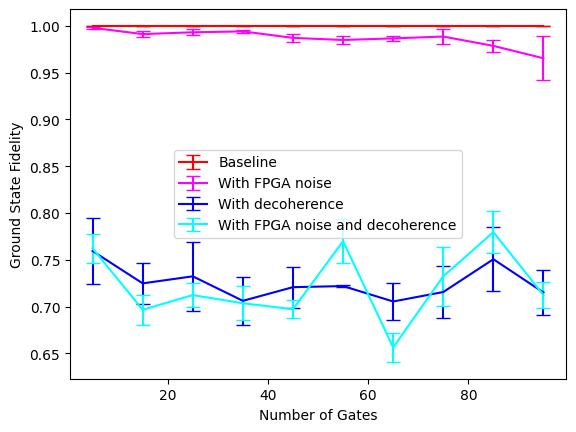

In [54]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='cyan', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")